<a href="https://colab.research.google.com/github/emm-gl/Referenz/blob/master/cont_challenge.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Task Description

The overall target of the task is:
1. Extraction of timeseries data for actual temperature (TEMPERATUR INNEN_IST) and pressure (DRUCK INNEN_IST) values per cycle, based on the overall timeseries data within the give timeframe (2024-04-08 00:00:00 until 2024-04-10 23:59:59).
2. Plot a set of temperature / pressure curves (line plot per cycle).
3. Describe your data transformation steps in a small document (can be PowerPoint Presentation or Markdown File).
4. BONUS (optional): Detect cycles that are not okay based on the average shape of the actual temperature (TEMPERATUR INNEN_IST) and pressure (DRUCK INNEN_IST) values per cycle.

In [1]:
import pandas as pd
import os
import pyarrow.parquet as pq
from datetime import datetime
import matplotlib.pyplot as plt

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


##Loading data:


####Get the config file:

In [7]:
# Specify the path of JSON file in Google Drive
json_file_path = "/content/drive/My Drive/continental_challenge/ct-oesl-hiring-challenge-main/data/config/datapoints.json"

# Load the JSON file into a DataFrame
df_config = pd.read_json(json_file_path)

# Display the DataFrame
df_config

,uuid,label,config
0,00f9c223-6fd4-45ec-8ee2-62b9458c98fc,BETRIEBSINTERNE AUFTRAGSNUMMER,"{'rate': 'diff', 'source': {'name': 'datablock..."
1,9d7f979a-c50e-494c-9ee0-082eabe3143f,SAP BEZEICHNUNG,"{'rate': 'diff', 'source': {'name': 'datablock..."
2,8a1c7509-3c14-4f8f-b81c-0d44190ea305,ARTIKELNUMMER,"{'rate': 'diff', 'source': {'name': 'datablock..."
3,6a295488-d312-4c35-9c35-7347488f9846,AUFTRAGSMENGE_SOLL,"{'rate': 'diff', 'source': {'name': 'datablock..."
4,5cbb4233-dcbb-4e96-9111-0f0c36633303,AUFTRAGSMENGE_IST,"{'rate': 'diff', 'source': {'name': 'datablock..."
...,...,...,...
315,13e090fc-7683-4c8b-863f-0816dce05f55,DATEN.MIN_SOLLTEMP,"{'rate': 'diff', 'source': {'name': 'datablock..."
316,c053ad11-d895-4d7a-b02a-aa95f80b6618,DATEN.ISTDRUCK,"{'rate': 'diff', 'source': {'name': 'datablock..."
317,df83a9c8-aac7-4331-b6b5-a36d8d5c8c7d,ANALOGE_ISTWERTE.IST_TEMPERATUR.ISTWERT_INT,"{'rate': 'diff', 'source': {'name': 'datablock..."
318,2af6484d-a002-4404-ba05-30b960e8a9ba,ANALOGE_ISTWERTE.PEW_518.ISTWERT_INT,"{'rate': 'diff', 'source': {'name': 'datablock..."



According the config File:

89. TEMPERATUR INNEN_IST    
    UUID: 5cde150d-c044-4e55-8c48-73321e0c0f27     
    Data type: INT16

90. DRUCK INNEN_IST      
    UUID: 67da707a-735b-497d-9870-40349919814c     
    Data type: INT16

---

####Get the temperature dataframe:

In [8]:
# Function to search for parquet files with a certain file name (UUID) in a directory and its subdirectories,
# then create a dataframe with all the found parquet files

def get_data(file_name, root_dir):
    parquet_files = []
    for root, dirs, files in os.walk(root_dir):
        for file in files:
            if file.endswith('.parquet') and file_name in file:
                parquet_files.append(os.path.join(root, file))

    # Create an empty DataFrame to store the combined data from all Parquet files
    df = pd.DataFrame()

    # Read each Parquet file and extract its content into the combined DataFrame
    for file_path in parquet_files:
        parquet_files = pq.read_table(file_path).to_pandas()
        df = pd.concat([df, parquet_files], ignore_index=True)

    return df

In [148]:
# Get the temperature data:
uuid_temp = "5cde150d-c044-4e55-8c48-73321e0c0f27"
root_dir = "/content/drive/My Drive/continental_challenge/ct-oesl-hiring-challenge-main/data/machine_data/"

df_temp = get_data(uuid_temp, root_dir)
df_temp.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 412769 entries, 0 to 412768
Data columns (total 10 columns):
 #   Column           Non-Null Count   Dtype  
---  ------           --------------   -----  
 0   uuid             412769 non-null  object 
 1   sequence_number  412769 non-null  int32  
 2   systime          412769 non-null  int64  
 3   plctime          412769 non-null  int64  
 4   is_delta         412769 non-null  bool   
 5   value_integer    412769 non-null  int64  
 6   value_string     0 non-null       object 
 7   value_double     0 non-null       float64
 8   value_bool       0 non-null       object 
 9   value_bytes      0 non-null       object 
dtypes: bool(1), float64(1), int32(1), int64(3), object(4)
memory usage: 27.2+ MB


Neither NaNs nor nulls nor mixed data types in labels: "systime" and "value_integer"

In [104]:
#Transform timestamp from PLC to date time format:

df_temperature_time = df_temp

#Convert the timestamp "systime" to datetime format in a new column:
df_temperature_time["system_time"] = df_temperature_time['systime'].apply(lambda x: x / 1e9)
df_temperature_time["system_time"] = pd.to_datetime(df_temperature_time['system_time'], unit='s')

#add ingestion_date
df_temperature_time["ingestion_date"] = datetime.now()


In [105]:
#Filter data:

# Define start and end dates:
start_date = pd.to_datetime('2024-04-08 00:00:00')   #YY-MM-DD
end_date = pd.to_datetime('2024-04-10 23:59:59')     #YY-MM-DD

# Filter rows where 'date' is within the range (inclusive)
df_temperature_filtered = df_temperature_time[(df_temperature_time['system_time'] >= start_date) & (df_temperature_time['system_time'] <= end_date)]

In [152]:
#Select only the required columns

df_temperature = df_temperature_filtered[["uuid",
                                           "sequence_number",
                                           "systime",
                                           "plctime",
                                           "is_delta",
                                           "value_integer",
                                           "system_time",
                                           "ingestion_date"
                                           ]]

In [ ]:
df_temperature

## Plotting:

In [174]:
def plot(df, y_column_name):
    """
    Plots a specified column of the resampled DataFrame.

    Parameters:
        df_resampled (DataFrame): Resampled DataFrame containing datetime index.
        column_name (str): Name of the column to plot.

    Returns:
        None
    """
    #Isolate numerical data
    df_plot = df[["value_integer", "system_time", "ingestion_date"]]
    df_plot.set_index('system_time', inplace=True)

    #Resample each second to plot propperly
    df_resampled = df_plot.resample('S').mean()

    plt.figure(figsize=(20, 6))  # Adjust figure size as needed
    plt.plot(df_resampled[y_column_name])
    plt.xlabel('Date')    # Add label for x-axis
    plt.ylabel('Temperature units')    # Add label for y-axis
    plt.title('Temperature data')  # Add title to the plot
    plt.grid(True)                # Add gridlines
    plt.show()

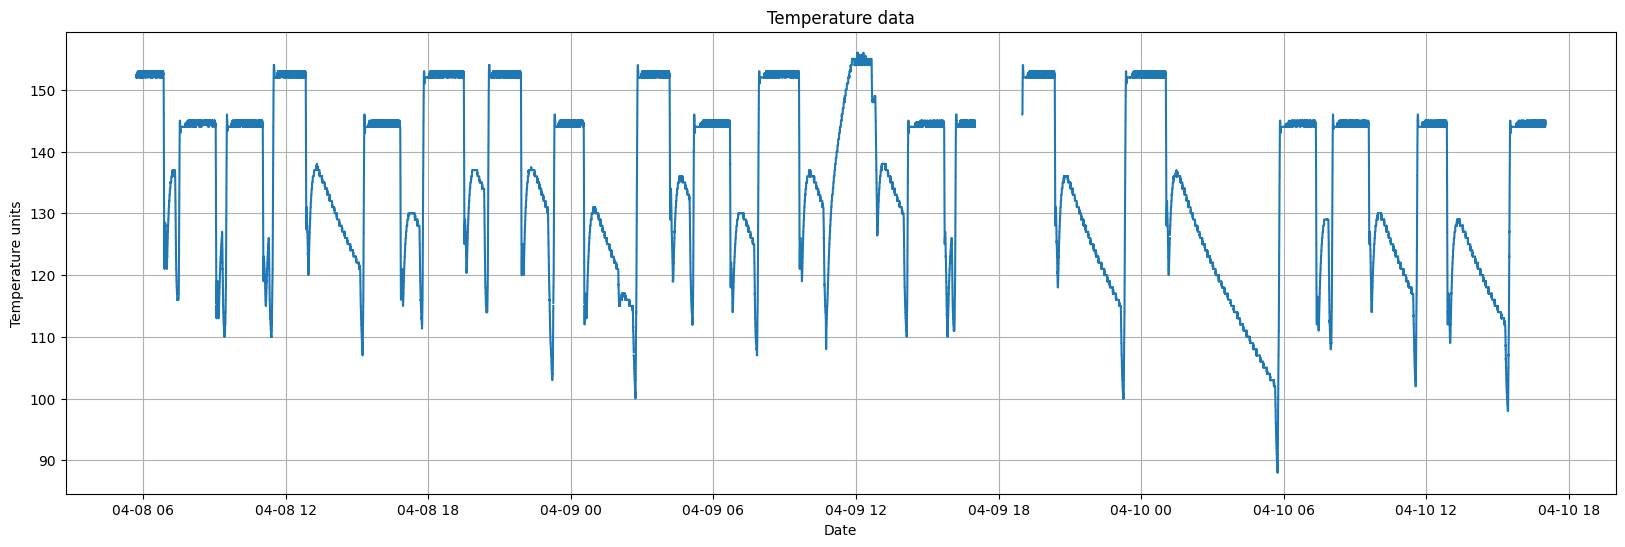

In [175]:
plot(df_temperature, "value_integer")

##demo temp:

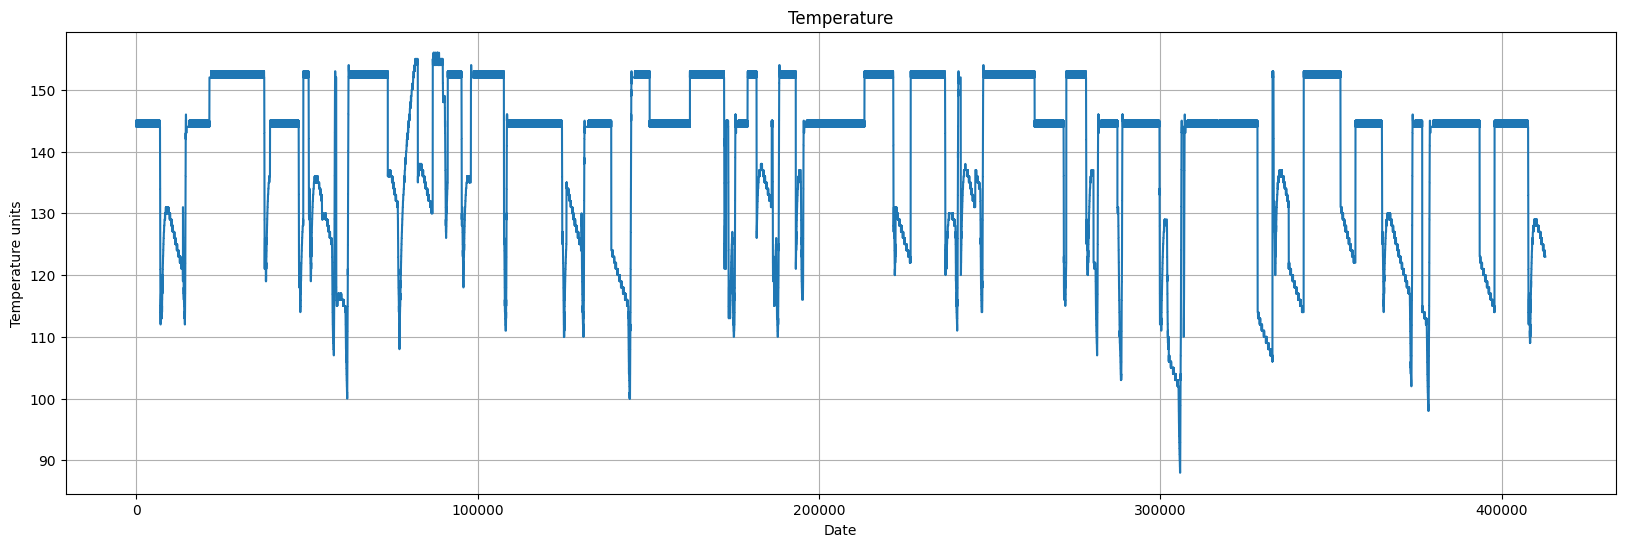

In [108]:
#Plot temperature:
%matplotlib inline

# Plot a certain column
plt.figure(figsize=(20, 6))  # Adjust figure size as needed
plt.plot(df_temperature['value_integer'])
plt.xlabel('Date')    # Add label for x-axis
plt.ylabel('Temperature units')    # Add label for y-axis
plt.title('Temperature')# Add title to the plot
plt.grid(True)                # Add gridlines
plt.show()                    # Show the plot

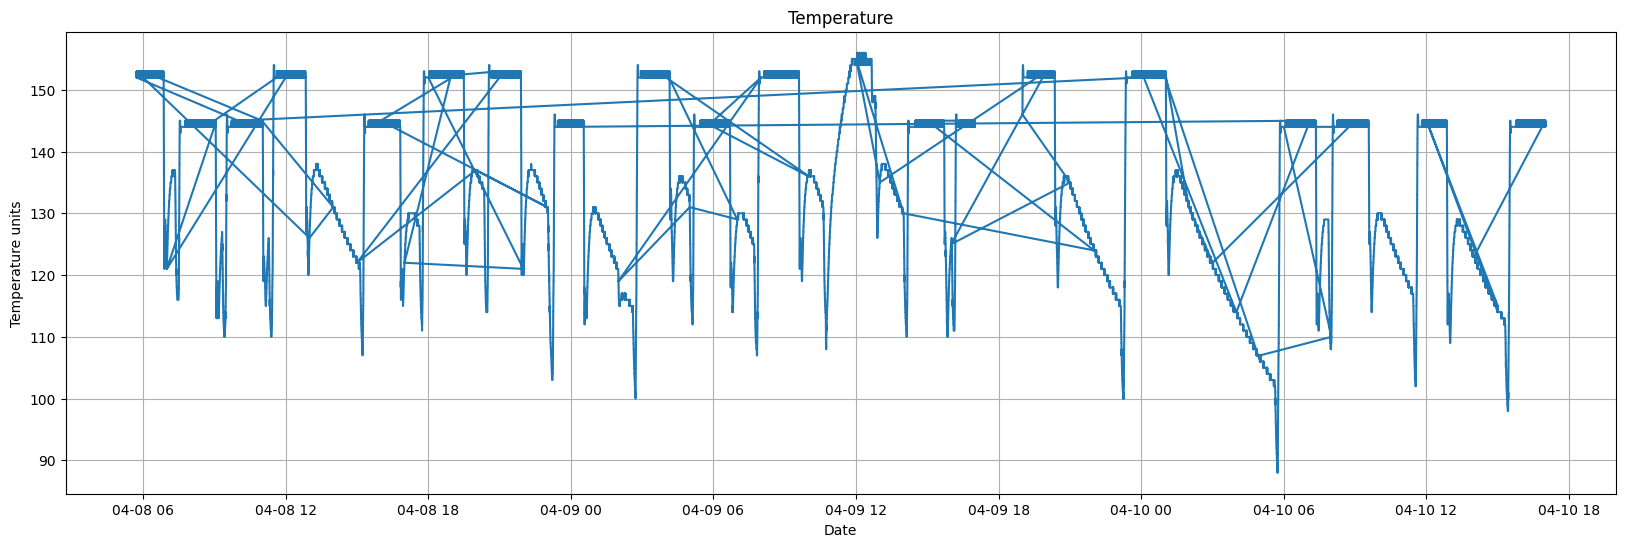

In [109]:
# Plot a certain column
plt.figure(figsize=(20, 6))  # Adjust figure size as needed
plt.plot(df_temperature['system_time'], df_temperature['value_integer'])
plt.xlabel('Date')    # Add label for x-axis
plt.ylabel('Temperature units')    # Add label for y-axis
plt.title('Temperature')# Add title to the plot
plt.grid(True)                # Add gridlines
plt.show()                    # Show the plot

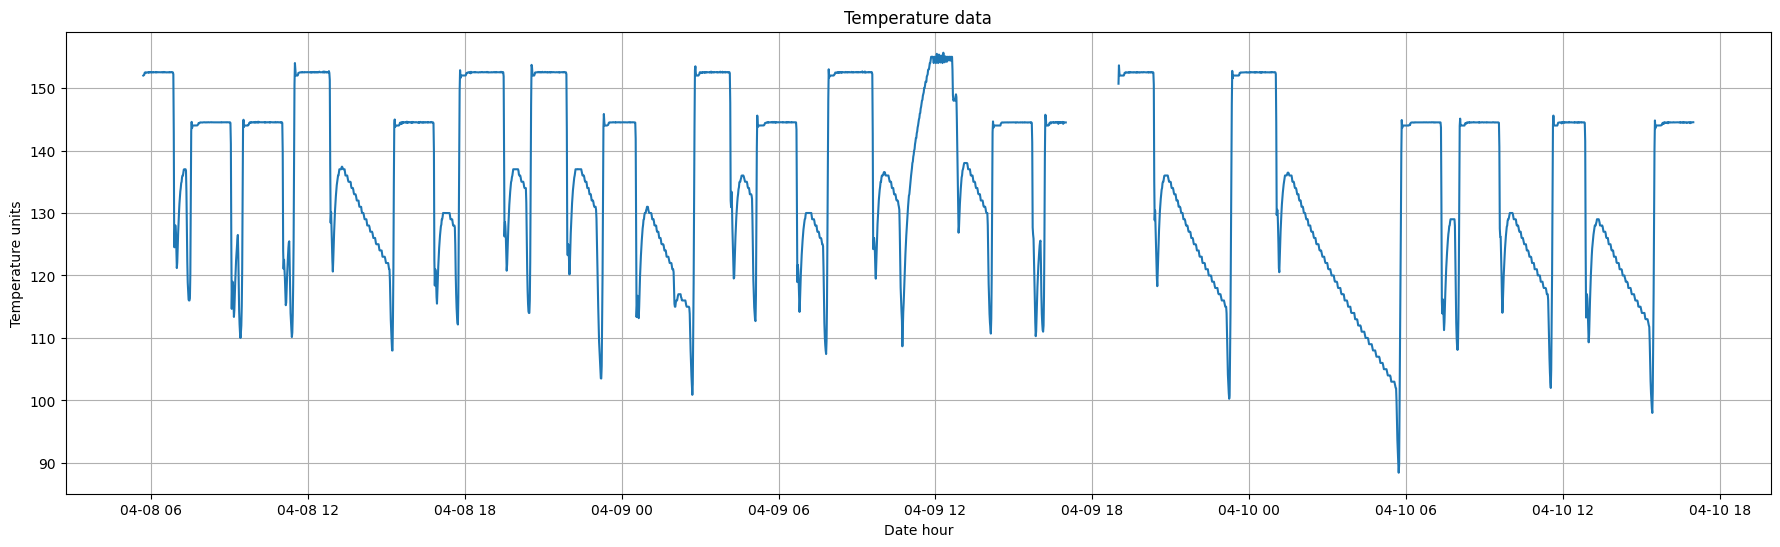

In [173]:
#Resampling each second to plot properly:
df_plottig = df_temperature[["value_integer",
                              "system_time",
                              "ingestion_date"]]

df_resampled = df_plottig.resample('T', on='system_time').mean()

#Plot temperature:
%matplotlib inline

# Plot a certain column
plt.figure(figsize=(22, 6))  # Adjust figure size as needed
plt.plot(df_resampled['value_integer'])
plt.xlabel('Date hour')    # Add label for x-axis
plt.ylabel('Temperature units')    # Add label for y-axis
plt.title('Temperature data')# Add title to the plot
plt.grid(True)                # Add gridlines
plt.show()

In [ ]:
#Extraction of timeseries data for actual pressure (DRUCK INNEN_IST)

# Define the pattern of the file name you want to search for
file_name_druck = '67da707a-735b-497d-9870-40349919814c'

parquet_files = find_files(file_name_druck)

# Create an empty DataFrame to store the combined data from all Parquet files
df_druck = pd.DataFrame()

# Read each Parquet file and extract its content into the combined DataFrame
for file_path in parquet_files:
    parquet_data = pq.read_table(file_path).to_pandas()
    df_druck = pd.concat([df_druck, parquet_data], ignore_index=True)

In [ ]:
df_druck

To do's:
Revisar que no haya valores nulos, Nan, en los valores de integer
Sacar estadística descriptiva para los value integer para analizar



In [ ]:
#Extraction of timeseries data for actual pressure (DRUCK INNEN_IST)

# Define the pattern of the file name you want to search for
file_name_pattern_druck = '67da707a-735b-497d-9870-40349919814c'

parquet_files = find_files(root_directory, file_name_pattern_druck)

# Create an empty DataFrame to store the combined data from all Parquet files
df_druck = pd.DataFrame()

# Read each Parquet file and extract its content into the combined DataFrame
for file_path in parquet_files:
    parquet_data = pq.read_table(file_path).to_pandas()
    df_druck = pd.concat([df_druck, parquet_data], ignore_index=True)

In [ ]:
df_druck

In [ ]:
#Plot Druck:

%matplotlib inline


import pandas as pd
import matplotlib.pyplot as plt

# Assuming you have already read the Parquet file into a DataFrame 'df'
# If not, replace 'df' with your DataFrame variable

# Plot a certain column
plt.figure(figsize=(10, 6))  # Adjust figure size as needed
plt.plot(df_druck['value_integer'])  # Replace 'column_name' with the name of the column you want to plot
plt.xlabel('X-axis label')    # Add label for x-axis
plt.ylabel('Value Integer')    # Add label for y-axis
plt.title('Druck')# Add title to the plot
plt.grid(True)                # Add gridlines
plt.show()                    # Show the plot